In [ ]:
import os
import shutil
import kagglehub
import numpy as npl*
import tensorflow as tf
from PIL import Image, UnidentifiedImageError
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import Callbacka
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('cuda' if torch.cuda.is_available() else 'cpu')

cuda


In [3]:
class AccuracyChangeCallback(Callback):
    def __init__(self, min_epochs, min_delta):
        super(AccuracyChangeCallback, self).__init__()
        self.min_epochs = min_epochs
        self.min_delta = min_delta
        self.last_accuracy = None

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get("accuracy")
        if epoch + 1 < self.min_epochs:
            self.last_accuracy = current_accuracy
            return

        if self.last_accuracy is not None:
            accuracy_change = current_accuracy - self.last_accuracy
            if accuracy_change < self.min_delta:
                print(f"\nAccuracy change {accuracy_change:.4f} is less than {self.min_delta}. Stopping training.")
                self.model.stop_training = True

        self.last_accuracy = current_accuracy

In [4]:
destination="/content"

In [5]:

    print("Downloading the dataset...")
    dataset_path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

    if not os.path.exists(destination):
        os.makedirs(destination)

    for item in os.listdir(dataset_path):
        src_path = os.path.join(dataset_path, item)
        dest_path = os.path.join(destination, item)
        if os.path.isdir(src_path):
            shutil.copytree(src_path, dest_path, dirs_exist_ok=True)
        else:
            shutil.copy2(src_path, dest_path)

    print("Dataset moved to:", destination)

Dataset moved to: /content


In [6]:
data_dir = "/content/Dataset_BUSI_with_GT"

In [7]:
def load_image_paths_and_labels(data_dir):
    """
    Load valid image paths and their corresponding labels from the dataset directory.

    Args:
        data_dir (str): Path to the dataset directory containing subdirectories for each class.

    Returns:
        list: A list of valid image paths.
        list: A list of corresponding labels.
    """
    image_paths, labels = [], []
    for label, category in enumerate(os.listdir(data_dir)):
        category_path = os.path.join(data_dir, category)
        if not os.path.isdir(category_path):
            continue
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:

                with Image.open(img_path) as img:
                    img.verify()
                image_paths.append(img_path)
                labels.append(label)
            except (UnidentifiedImageError, OSError):
                print(f"Skipping invalid image: {img_path}")
                continue
    return image_paths, labels


In [8]:
image_paths, labels = load_image_paths_and_labels(data_dir)

In [9]:
categories = [category for category in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, category))]

In [10]:
counts = Counter(labels)
print("Category distribution:", dict(counts))

Category distribution: {0: 266, 1: 421, 2: 891}


In [11]:
sizes = [Image.open(p).size for p in image_paths]
widths, heights = zip(*sizes)
print(f"Image Sizes: Min ({min(widths)}x{min(heights)}), Max ({max(widths)}x{max(heights)}), Avg ({np.mean(widths):.1f}x{np.mean(heights):.1f})")

Image Sizes: Min (190x310), Max (1048x719), Avg (616.1x501.6)


Sample Images:


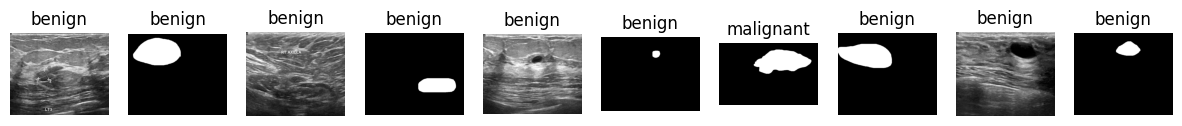

In [12]:
print("Sample Images:")
plt.figure(figsize=(15, 5))
for i in range(10):
    idx = random.randint(0, len(image_paths) - 1)
    img = Image.open(image_paths[idx])
    plt.subplot(1, 10, i + 1)
    plt.imshow(img)
    plt.title(categories[labels[idx]])
    plt.axis("off")
plt.show()

In [13]:
image_paths, labels = load_image_paths_and_labels(data_dir)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [14]:
class_weights = torch.tensor(
    [1.0 / Counter(y_train).get(i, 1) for i in range(len(categories))]
).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [15]:
class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to match pretrained model input
])


train_loader = DataLoader(
    BreastCancerDataset(X_train, y_train, transform=train_transform),
    batch_size=32, shuffle=True
)

test_loader = DataLoader(
    BreastCancerDataset(X_test, y_test, transform=test_transform),
    batch_size=32, shuffle=False
)

In [16]:
baseline_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
baseline_model.fc = nn.Sequential(
    nn.Linear(baseline_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(categories))
)
baseline_model = baseline_model.to(device)

In [17]:
class EnhancedModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(EnhancedModel, self).__init__()
        self.base = base_model

        self.fc = nn.Sequential(
            nn.Linear(3, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base(x)

        x = x.view(x.size(0), -1)

        return self.fc(x)

enhanced_model = EnhancedModel(baseline_model, len(set(labels))).to(device)

In [18]:
def train_model(model, loader, optimizer, criterion, scheduler=None):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if scheduler:
        scheduler.step()  # Update the scheduler if provided
    return total_loss / len(loader)

In [19]:
def validate_model(model, loader, criterion):
    model.eval()
    total_loss, y_true, y_pred = 0, [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    metrics = {
        "loss": total_loss / len(loader),
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted")
    }
    return metrics

In [20]:
def train_and_validate(model, train_loader, test_loader, epochs=15):
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    best_accuracy = 0

    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, scheduler)
        metrics = validate_model(model, test_loader, criterion)
        if metrics["accuracy"] > best_accuracy:
            best_accuracy = metrics["accuracy"]
            torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Val Metrics: {metrics}")

    return model

In [21]:
print("Training Baseline Model...")
trained_baseline = train_and_validate(baseline_model, train_loader, test_loader)

Training Baseline Model...
Epoch 1/15 | Train Loss: 0.6428 | Val Metrics: {'loss': 0.6077143520116806, 'accuracy': 0.75, 'f1': 0.7530239349433717, 'precision': 0.773089215960245, 'recall': 0.75}
Epoch 2/15 | Train Loss: 0.5063 | Val Metrics: {'loss': 0.9364059329032898, 'accuracy': 0.7278481012658228, 'f1': 0.7038624748464074, 'precision': 0.7873927268826432, 'recall': 0.7278481012658228}
Epoch 3/15 | Train Loss: 0.4293 | Val Metrics: {'loss': 0.5025643140077591, 'accuracy': 0.819620253164557, 'f1': 0.8188833314126527, 'precision': 0.820150349035212, 'recall': 0.819620253164557}
Epoch 4/15 | Train Loss: 0.4290 | Val Metrics: {'loss': 0.8514767304062844, 'accuracy': 0.7246835443037974, 'f1': 0.7261745139674041, 'precision': 0.769992689122587, 'recall': 0.7246835443037974}
Epoch 5/15 | Train Loss: 0.3691 | Val Metrics: {'loss': 0.4382022276520729, 'accuracy': 0.7848101265822784, 'f1': 0.7910343306483946, 'precision': 0.8336410819942514, 'recall': 0.7848101265822784}
Epoch 6/15 | Train Lo

In [22]:
print("\nTraining Enhanced Model...")
trained_enhanced = train_and_validate(enhanced_model, train_loader, test_loader)


Training Enhanced Model...
Epoch 1/15 | Train Loss: 0.4302 | Val Metrics: {'loss': 1.3745332419872285, 'accuracy': 0.7468354430379747, 'f1': 0.7406149402202594, 'precision': 0.7524195955434425, 'recall': 0.7468354430379747}
Epoch 2/15 | Train Loss: 0.3598 | Val Metrics: {'loss': 0.9373920172452926, 'accuracy': 0.7911392405063291, 'f1': 0.7931889933249641, 'precision': 0.8285136023888156, 'recall': 0.7911392405063291}
Epoch 3/15 | Train Loss: 0.3230 | Val Metrics: {'loss': 1.9396553575992583, 'accuracy': 0.6772151898734177, 'f1': 0.681550411586547, 'precision': 0.7945620583809341, 'recall': 0.6772151898734177}
Epoch 4/15 | Train Loss: 0.3621 | Val Metrics: {'loss': 1.6172076046466828, 'accuracy': 0.7151898734177216, 'f1': 0.7234515582914968, 'precision': 0.7890006172320712, 'recall': 0.7151898734177216}
Epoch 5/15 | Train Loss: 0.3408 | Val Metrics: {'loss': 0.3700097516179085, 'accuracy': 0.8259493670886076, 'f1': 0.82712217589174, 'precision': 0.8309248404730727, 'recall': 0.82594936

In [23]:
data_dir = "/content/Dataset_BUSI_with_GT"
image_paths, labels = load_image_paths_and_labels(data_dir)
categories = os.listdir(data_dir)

In [24]:
counts = Counter(labels)
print("Category distribution:", dict(counts))

Category distribution: {0: 266, 1: 421, 2: 891}


In [25]:
sizes = [Image.open(p).size for p in image_paths]
widths, heights = zip(*sizes)
print(f"Image Sizes: Min ({min(widths)}x{min(heights)}), Max ({max(widths)}x{max(heights)}), Avg ({np.mean(widths):.1f}x{np.mean(heights):.1f})")

Image Sizes: Min (190x310), Max (1048x719), Avg (616.1x501.6)


In [26]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


In [28]:
train_loader = DataLoader(BreastCancerDataset(X_train, y_train, transform), batch_size=32, shuffle=True)
test_loader = DataLoader(BreastCancerDataset(X_test, y_test, transform), batch_size=32, shuffle=False)

In [29]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(categories))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
model = model.to(device)
trained_model = train_and_validate(model, train_loader, test_loader, epochs=15)

Epoch 1/15 | Train Loss: 0.7627 | Val Metrics: {'loss': 0.9218374937772751, 'accuracy': 0.6645569620253164, 'f1': 0.6642488029204001, 'precision': 0.777905746051096, 'recall': 0.6645569620253164}
Epoch 2/15 | Train Loss: 0.4385 | Val Metrics: {'loss': 1.456483244895935, 'accuracy': 0.5917721518987342, 'f1': 0.5723084938272278, 'precision': 0.7513507552531401, 'recall': 0.5917721518987342}
Epoch 3/15 | Train Loss: 0.4367 | Val Metrics: {'loss': 0.5739918291568756, 'accuracy': 0.7911392405063291, 'f1': 0.7955718255193401, 'precision': 0.8339478961577642, 'recall': 0.7911392405063291}
Epoch 4/15 | Train Loss: 0.3051 | Val Metrics: {'loss': 0.47700878977775574, 'accuracy': 0.8354430379746836, 'f1': 0.8302773856541087, 'precision': 0.8530871625808334, 'recall': 0.8354430379746836}
Epoch 5/15 | Train Loss: 0.3080 | Val Metrics: {'loss': 0.43189420104026793, 'accuracy': 0.8132911392405063, 'f1': 0.8151580230058068, 'precision': 0.8291743514563004, 'recall': 0.8132911392405063}
Epoch 6/15 | Tr

In [31]:
baseline_metrics = validate_model(trained_baseline, test_loader, nn.CrossEntropyLoss())
print("Baseline Model Metrics:", baseline_metrics)

Baseline Model Metrics: {'loss': 0.37995367497205734, 'accuracy': 0.879746835443038, 'f1': 0.8796110396551052, 'precision': 0.8808656418264, 'recall': 0.879746835443038}


In [32]:
enhanced_metrics = validate_model(trained_enhanced, test_loader, nn.CrossEntropyLoss())
print("Enhanced Model Metrics:", enhanced_metrics)


Enhanced Model Metrics: {'loss': 0.30996645241975784, 'accuracy': 0.8765822784810127, 'f1': 0.8764516878880336, 'precision': 0.8773682171631926, 'recall': 0.8765822784810127}


In [33]:
new_metrics = validate_model(trained_model, test_loader, nn.CrossEntropyLoss())
print("Metrics after adding new data:", new_metrics)

Metrics after adding new data: {'loss': 0.3614355232566595, 'accuracy': 0.8987341772151899, 'f1': 0.8982529836251733, 'precision': 0.9007235427538284, 'recall': 0.8987341772151899}
